In [65]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random

import urllib.request
import io
import zipfile

In [66]:
"""Implement a version of Newmann-Ziff Algorithm, which takes as input a networkx
graph and an ordering of its nodes and outputs the sizes of all the percolation clusters
in the graph as a function of the fraction of removed nodes. The algorithm works by
reversing the percolation process, starting from a graph where all nodes are removed
and adding nodes one by one while keeping track of the size of the clusters.
"""
def newmann_ziff(G : nx.Graph, node_order : list):
    G__ = G.copy()
    n = G.number_of_nodes()
    cluster_sizes, cluster_labels = np.zeros(n, dtype=int), np.zeros(n, dtype=int)
    nodes_added = set()
    c = 0

    log = np.zeros((n,n), dtype=int)
    for node in node_order:
        G__.add_node(node)
        nodes_added.add(node)
        cluster_sizes[c] += 1
        cluster_labels[node] = c

        #print('nodes added', nodes_added)
        for neighbor in G.neighbors(node):
            if neighbor in nodes_added:
                G__.add_edge(node, neighbor)
                #print("Added edge between {} and {}".format(node, neighbor))
            
            if cluster_labels[neighbor] != c and neighbor in nodes_added:
                #print("Merged cluster {} into cluster {}".format(cluster_labels[neighbor], c))
                cluster_sizes[cluster_labels[neighbor]] -= 1
                cluster_labels[neighbor] = c
                cluster_sizes[c] += 1

                #print("Cluster {} now has size {}".format(cluster_labels[node], cluster_sizes[c]))
               
        log[c,:] = cluster_sizes
        c += 1

    return log

In [67]:
def gen_exp_graph(N, gamma):
    """
    Returns a networx graph according to a power law degree distribution
    """
    sum_is_odd = True

    sequence = []
    
    while sum_is_odd:
        sequence = np.array(nx.utils.powerlaw_sequence(N, gamma), dtype=int)
        sum_is_odd = np.sum(sequence) % 2 == 1


    return nx.configuration_model(sequence)

In [68]:
def sample_ER(N, p):
    rd = np.random.rand(N,N)
    # we multiply by 2 since when iterating over nodes (i,j) each edge is considered twice
    A = np.triu(rd < (p))
    np.fill_diagonal(A, 0)
    return nx.from_numpy_matrix(A)

In [79]:
N = 100
graphs = []

graphs.append(gen_exp_graph(N, 2.3))
graphs.append(sample_ER(N, 0.1))
graphs.append(nx.planted_partition_graph(5, 20, 0.1, 0.01))
graphs.append(nx.karate_club_graph())


In [119]:
weights = []
f_1 = lambda G : np.random.random(G.number_of_nodes())
f_2 = lambda G : nx.betweenness_centrality(G).values()
f_3 = lambda G : nx.closeness_centrality(G).values()

weights.append(f_1)
weights.append(f_2)
weights.append(f_3)

labels = ['Uniform Random', 'Betweenness', 'Closeness']


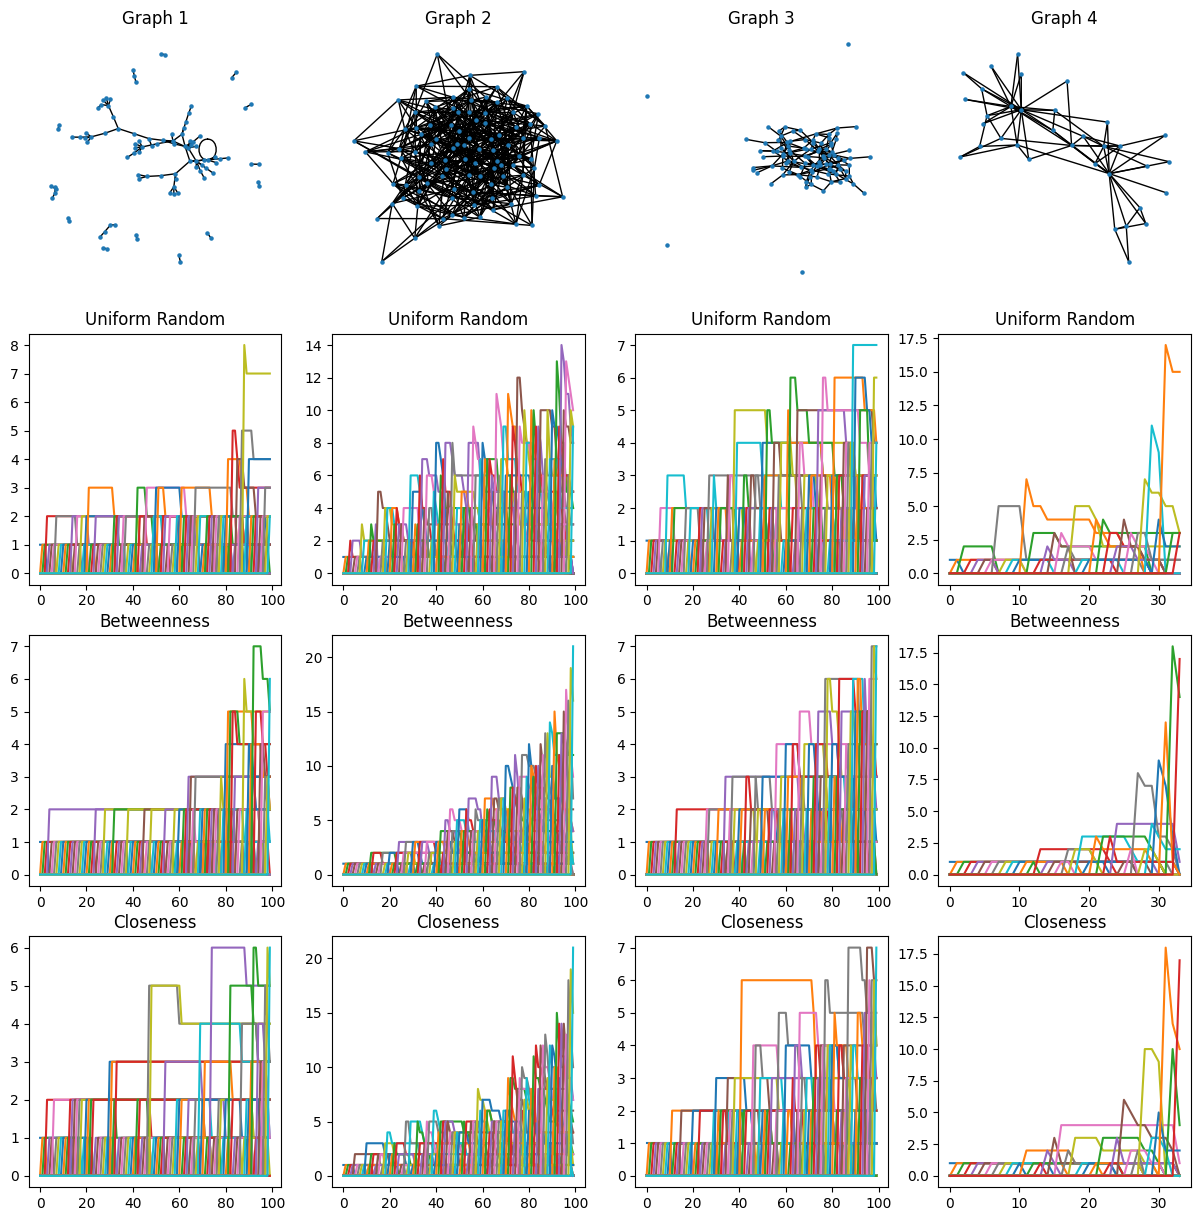

In [120]:
fig, axs = plt.subplots(nrows=len(weights) + 1, ncols=len(graphs), figsize=(15, 15))
for i in range(len(graphs)):
    graph = graphs[i]
    ls = np.array(list(graph.nodes))

    nx.draw(graph, ax=axs[0, i], node_size=5)
    axs[0, i].set_title("Graph {}".format(i + 1))

    for j in range(len(weights)):
        weight = list(weights[j](graph))
        #print(weight)
        ind = np.argsort(weight)
        #print(ind)
        ls__ = ls.copy()[ind]
        #print(ls__)
        f = newmann_ziff(graph, ls__)
        #print(f)
        axs[j + 1, i].plot(f)
        axs[j + 1, i].set_title(labels[j])